Show how UK demand for products has evolved over time.

In [1]:
import pandas as pd
flows = pd.read_csv('../data/flows.csv')

Define the Sankey diagram structure and draw:

In [2]:
from palettable.cartocolors.qualitative import Prism_10, Antique_10
C = Prism_10.hex_colors[1:]

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
sectors = ['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15a', '15b', '16', '17', '18', '19', '20']

sector_names = [
    'Fasteners',
    'Hand tools, cutlery, instruments',
    'Packaging, industrial/domestic hollow-ware',
    'Other metal goods',
    'Electrical engineering, incl. appliances',
    'Agricultural machinery',
    'Metal working tools & engineering tools',
    'Construction, earth moving & handling equipment',
    'Other mechanical engineering',
    'Industrial & process plant',
    'Construction & fabricated steelwork',
    'Motor vehicles: BIW',
    'Motor vehicles: drivetrain, chassis, trimmings',
    'Other transport',
    'Coal, coke, petroleum & natural gas',
    'Gas, electricity & water',
    'Chemical & allied industries',
    'Other UK consumers'
]

sector_groups = [
    ('Metal goods', ['4', '5', '6', '7']),
    ('Elec. eng', ['8']),
    ('Mech. eng', ['9', '10', '11', '12', '13']),
    ('Construction', ['14']),
    ('Transport', ['15a', '15b', '16']),
    ('Energy/water', ['17', '18', '19']),
    ('Other', ['20']),
]

In [5]:
# from https://stackoverflow.com/a/49601444/1615465
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [6]:
palette = {k[0]: '#999' for k in sector_groups}
palette['Metal goods'] = C[0]
palette['Elec. eng'] = C[1]
palette['Mech. eng'] = C[2]
palette['Construction'] = C[3]
palette['Transport'] = C[4]
palette['Energy/water'] = C[5]
palette['Other'] = C[6]

palette2 = []
for k, grp in sector_groups:
    for i in range(len(grp)):
        palette2.append(palette[k] if i % 2 else lighten_color(palette[k], 0.9))

First, all UK demand, including imports:

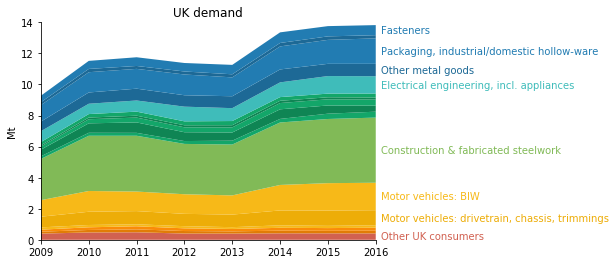

In [11]:
all_demand = flows \
    .query('target == "uk_demand"') \
    .groupby(['year', 'material'])['value'].sum() \
    .unstack() \
    [sectors[::-1]] \
    / 1e3

fig, ax = plt.subplots(figsize=(6, 4))
ax.stackplot(all_demand.index.values, all_demand.values.T, colors=palette2[::-1]);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(2009, 2016)
ax.set_ylim(0, 14)
ax.set_ylabel('Mt')
ax.set_title('UK demand')

y1 = all_demand.loc[2016, sectors[::-1]]
y = 0
for dy, name, c in zip(y1, sector_names[::-1], palette2[::-1]):
    y += dy / 2
    if dy > 0.4:
        ax.text(2016.1, y, name, va='center', color=c)
    y += dy / 2
    
fig.savefig('../figures/uk_demand_over_time.pdf', bbox_inches='tight')

Perhaps also only the domestically-satisfied demand, excluding imports:

In [16]:
imported_final = flows.query('source == "product_imports"') \
    .groupby(['year', 'material'])['value'].sum()

uk_manufac = flows.query('target == "uk_demand" and source != "product_imports"') \
    .groupby(['year', 'material'])['value'].sum()

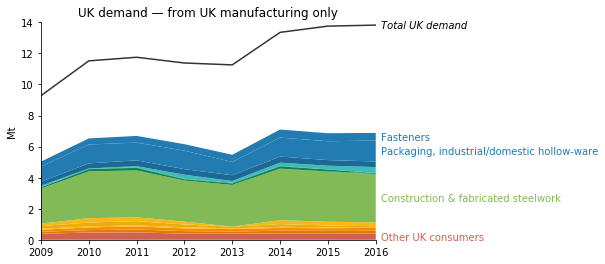

In [18]:
dom_demand = uk_manufac \
    .unstack() \
    .reindex(columns=sectors[::-1]) \
    .fillna(0.0) \
    / 1e3

#all_demand.plot.area(color=palette2[::-1], lw=1, edgecolor='white')
fig, ax = plt.subplots(figsize=(6, 4))
ax.stackplot(dom_demand.index.values, dom_demand.values.T, colors=palette2[::-1]);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(2009, 2016)
ax.set_ylabel('Mt')
ax.set_title('UK demand — from UK manufacturing only')

y1 = dom_demand.loc[2016, sectors[::-1]]
y = 0
for dy, name, c in zip(y1, sector_names[::-1], palette2[::-1]):
    y += dy / 2
    if dy > 0.4:
        ax.text(2016.1, y, name, va='center', color=c)
    y += dy / 2
    
fig.savefig('../figures/uk_demand_over_time_excluding_imports.pdf', bbox_inches='tight')

ax.set_ylim(0, 14)
ax.plot(dom_demand.index.values, all_demand.sum(axis=1).values, 'k', lw=1.5, alpha=0.8)
ax.text(2016.1, all_demand.sum(axis=1).values[-1], 'Total UK demand', va='center', fontstyle='italic')
fig.savefig('../figures/uk_demand_over_time_excluding_imports_same_scale.pdf', bbox_inches='tight')

And now only the part of UK manufactured products that were made from UK steel

In [26]:
sector_ids = ['sector %s' % s for s in sectors]
inputs = flows.query('target in @sector_ids').copy()
inputs['target'] = inputs['target'].str.lstrip('sector ')
inputs = inputs.groupby(['year', 'target', 'source'])['value'].sum().unstack()
inputs.index.names = ['year', 'material']

# Collect results together
scale = (uk_manufac / inputs.sum(axis=1))
results = pd.DataFrame({
    'UK produced steel':       scale * inputs['uk_production'],
    'Imported as semis':       scale * inputs['imports'],
    'Imported as components':  scale * inputs['component_imports'],
    'Imported as final goods': imported_final,
}).fillna(0)

results = results.reindex(sectors[::-1], level='material')
#results

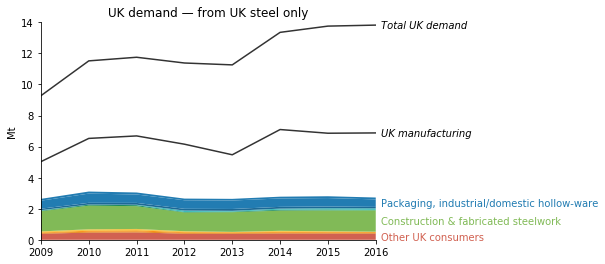

In [28]:
dom_demand_dom_steel = results['UK produced steel'] \
    .unstack() \
    .reindex(columns=sectors[::-1]) \
    .fillna(0.0) \
    / 1e3

#all_demand.plot.area(color=palette2[::-1], lw=1, edgecolor='white')
fig, ax = plt.subplots(figsize=(6, 4))
ax.stackplot(dom_demand_dom_steel.index.values, dom_demand_dom_steel.values.T, colors=palette2[::-1]);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(2009, 2016)
ax.set_ylabel('Mt')
ax.set_title('UK demand — from UK steel only')

y1 = dom_demand_dom_steel.loc[2016, sectors[::-1]]
y = 0
for dy, name, c in zip(y1, sector_names[::-1], palette2[::-1]):
    y += dy / 2
    if dy > 0.4:
        ax.text(2016.1, y, name, va='center', color=c)
    y += dy / 2
    
fig.savefig('../figures/uk_demand_over_time_uk_only.pdf', bbox_inches='tight')

ax.set_ylim(0, 14)

ax.plot(dom_demand.index.values, all_demand.sum(axis=1).values, 'k', lw=1.5, alpha=0.8)
ax.text(2016.1, all_demand.sum(axis=1).values[-1], 'Total UK demand', va='center', fontstyle='italic')

ax.plot(dom_demand.index.values, dom_demand.sum(axis=1).values, 'k', lw=1.5, alpha=0.8)
ax.text(2016.1, dom_demand.sum(axis=1).values[-1], 'UK manufacturing', va='center', fontstyle='italic')

fig.savefig('../figures/uk_demand_over_time_uk_only_same_scale.pdf', bbox_inches='tight')